In [1]:
# -*- coding: utf-8 -*-
"""Resnet50_cgcnn_upgrade.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Uzz8ALUJukf6q5Ng5q9FEkkzFc7tTxef
"""

# ===============================
# CG-CNN

# ===============================

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import roc_auc_score, classification_report
import random

# ===============================
# CONFIGURATION
# ===============================
IMG_DIR = "/content/drive/MyDrive/CGCNN_research/part_1"
MODEL_SAVE_PATH = "/content/drive/MyDrive/CGCNN_research/cgcnn_contextual.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
WINDOW_SIZE = 5          # 5x5 windows
G_RADIUS = 2             # ±2 pixels around seed (creates 5x5 = 25 windows per group)
N_IMAGES_PER_TASK = 20   # More images per task (was 5)
N_GROUPS = 100           # C=50 contextual groups (as specified)
WINDOWS_PER_GROUP = (2*G_RADIUS+1)**2  # 25 windows around each seed (5x5 grid in ±2 region)
N_TASKS = 2000          # More tasks for better convergence
REFINER_DIM = 1024        # Q' dimension

print(f"Device: {DEVICE}")
print(f"Window size: {WINDOW_SIZE}x{WINDOW_SIZE} (9 positions)")
print(f"Context radius: ±{G_RADIUS} (creates {(2*G_RADIUS+1)**2} positions per seed)")

Mounted at /content/drive
Device: cuda
Window size: 5x5 (9 positions)
Context radius: ±2 (creates 25 positions per seed)


In [2]:
# ===============================
# 1. DILATED RESNET BACKBONE
# ===============================
class DilatedResNetBackbone(nn.Module):
    """
    Modified ResNet50 with dilation to maintain spatial resolution.
    Output P: [B, 1024, 28, 28] - dense spatial resolution for contextual sampling
    Output Q: [B, 2048, 28, 28] - next block's features (baseline comparison)
    """
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Modify layer3 for dilation (keeps resolution at 28x28)
        layer3 = resnet.layer3
        if layer3[0].downsample is not None:
            layer3[0].downsample[0].stride = (1, 1)
        for block in layer3:
            if block.conv2.kernel_size == (3, 3):
                block.conv2.stride = (1, 1)
                block.conv2.dilation = (2, 2)
                block.conv2.padding = (2, 2)

        # P: intermediate features (layer3 output)
        self.to_P = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3
        )

        # Q: next block features (layer4 output) - for comparison
        self.to_Q = resnet.layer4

        # Freeze everything
        for param in self.parameters():
            param.requires_grad = False
        self.eval()

    def forward(self, x):
        """Returns both P and Q for later comparison"""
        with torch.no_grad():
            P = self.to_P(x)      # [B, 1024, 28, 28]
            Q = self.to_Q(P)      # [B, 2048, 28, 28]
        return P, Q

In [3]:
# ===============================
# 2. CG-CNN REFINER (Learns Q')
# ===============================
class CGCNNRefiner(nn.Module):
    """
    Learns Q' from P using contextual guidance.
    Input: P [B, 1024, H, W]
    Output: Q' [B, REFINER_DIM, H, W]
    """
    def __init__(self, in_dim=1024, refiner_dim=1024):
        super().__init__()

        self.refiner = nn.Sequential(
            nn.Conv2d(in_dim, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, refiner_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(refiner_dim),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(refiner_dim, refiner_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(refiner_dim),
            nn.ReLU(inplace=True)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, P):
        """P -> Q'"""
        return self.refiner(P)

    def get_global_features(self, P):
        """Extract image-level features"""
        Q_prime = self.refiner(P)
        return F.adaptive_avg_pool2d(Q_prime, (1, 1)).flatten(1)

In [4]:
# ===============================
# 3. CONTEXTUAL GROUP GENERATOR
# (Following Original CGCNN Logic)
# ===============================
class ContextualGroupGenerator:
    """Fixed version - extracts from P (not Q')"""
    def __init__(self, window_size=5, g_radius=2):
        self.window_size = window_size
        self.g = g_radius

    def extract_window(self, feature_map, cy, cx):
        """Extract window from feature map"""
        C, H, W = feature_map.shape
        half_w = self.window_size // 2

        y_start = max(0, cy - half_w)
        y_end = min(H, cy + half_w + 1)
        x_start = max(0, cx - half_w)
        x_end = min(W, cx + half_w + 1)

        window = feature_map[:, y_start:y_end, x_start:x_end]

        if window.shape[1] != self.window_size or window.shape[2] != self.window_size:
            window = F.interpolate(
                window.unsqueeze(0),
                size=(self.window_size, self.window_size),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

        return window

    def augment_window(self, window):
        """
        MINIMAL augmentation - only spatial flips.
        No channel dropout, noise, or scaling (preserves semantics).
        """
        aug_window = window.clone()

        # Only geometric transformations
        if random.random() < 0.5:
            aug_window = torch.flip(aug_window, dims=[-1])  # H-flip

        if random.random() < 0.5:
            aug_window = torch.flip(aug_window, dims=[-2])  # V-flip

        return aug_window

    def create_contextual_group_from_P(self, P_feature_map, seed_cy, seed_cx):
        """
        Extract contextual group from P (backbone features).
        Returns windows from P that will be refined by learnable network.
        """
        group_windows = []

        for dy in range(-self.g, self.g + 1):
            for dx in range(-self.g, self.g + 1):
                cy = seed_cy + dy
                cx = seed_cx + dx

                # Extract from P (fixed features)
                window = self.extract_window(P_feature_map, cy, cx)

                # Minimal augmentation
                aug_window = self.augment_window(window)

                group_windows.append(aug_window)

        return group_windows

    def create_task_from_P(self, backbone, dataset, n_images, n_groups):
        """
        FIXED: Extract windows from P (not Q').
        Returns raw P windows that refiner will process.
        """
        device = next(backbone.parameters()).device

        # 1. Extract P features from images
        image_indices = random.sample(range(len(dataset)), min(n_images, len(dataset)))
        P_maps = []

        for idx in image_indices:
            img = dataset[idx].unsqueeze(0).to(device)
            with torch.no_grad():
                P, _ = backbone(img)
            P_maps.append(P.squeeze(0))  # [1024, 28, 28]

        # 2. Sample seeds and extract windows from P
        all_windows = []
        all_labels = []

        for group_id in range(n_groups):
            # Random image and seed position
            P_map = random.choice(P_maps)
            C, H, W = P_map.shape

            margin = self.g + self.window_size // 2 + 1
            seed_cy = random.randint(margin, H - margin - 1)
            seed_cx = random.randint(margin, W - margin - 1)

            # Extract contextual group from P
            group_windows = self.create_contextual_group_from_P(P_map, seed_cy, seed_cx)

            for window in group_windows:
                all_windows.append(window)
                all_labels.append(group_id)

        X_P = torch.stack(all_windows)  # [N, 1024, 5, 5] - P windows
        y = torch.tensor(all_labels, dtype=torch.long)

        return X_P, y

In [5]:
# ===============================
# 4. DISCRIMINATOR
# ===============================
class Discriminator(nn.Module):
    """Classifies which contextual group a window belongs to"""
    def __init__(self, in_dim, n_classes, window_size=5):
        super().__init__()
        flat_dim = in_dim * window_size * window_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [6]:
# ===============================
# 5. CG-CNN TRAINING SYSTEM
# ===============================
class CGCNNTrainer:
    """Fixed trainer with proper E-M separation"""
    def __init__(self, backbone, refiner_dim=256, window_size=5,
                 g_radius=2, n_groups=64, device='cuda'):
        self.device = device
        self.n_groups = n_groups

        self.backbone = backbone.to(device)
        self.refiner = CGCNNRefiner(in_dim=1024, refiner_dim=refiner_dim).to(device)

        self.task_gen = ContextualGroupGenerator(window_size, g_radius)

        self.refiner_optimizer = torch.optim.Adam(
            self.refiner.parameters(),
            lr=1e-4,
            weight_decay=1e-5
        )

        self.task_accuracies = []
        self.losses_e = []
        self.losses_m = []

    def train_on_task(self, dataset, n_images=20, em_iterations=10):
        """
        FIXED: Proper E-M alternation.
        - Extract P windows once (fixed)
        - E-step: Train discriminator on Q' = refiner(P) with frozen refiner
        - M-step: Train refiner on same P windows with frozen discriminator
        """

        # 1. Generate task - extract P windows (ONCE, stays fixed)
        X_P, y_task = self.task_gen.create_task_from_P(
            self.backbone,
            dataset,
            n_images=n_images,
            n_groups=self.n_groups
        )
        X_P = X_P.to(self.device)  # [N, 1024, 5, 5] - P windows
        y_task = y_task.to(self.device)

        # 2. Create discriminator
        discriminator = Discriminator(
            in_dim=REFINER_DIM,
            n_classes=self.n_groups,
            window_size=WINDOW_SIZE
        ).to(self.device)

        disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # 3. E-M alternation
        for iteration in range(em_iterations):
            # ========== E-STEP ==========
            self.refiner.eval()
            discriminator.train()

            # Freeze refiner, unfreeze discriminator
            for p in self.refiner.parameters():
                p.requires_grad = False
            for p in discriminator.parameters():
                p.requires_grad = True

            # Refine P windows (no gradient through refiner)
            with torch.no_grad():
                Q_prime_windows = self.refiner(X_P)  # [N, 256, 5, 5]

            # Train discriminator
            disc_optimizer.zero_grad()
            logits = discriminator(Q_prime_windows)
            loss_e = criterion(logits, y_task)
            loss_e.backward()
            disc_optimizer.step()

            # ========== M-STEP ==========
            self.refiner.train()
            discriminator.eval()

            # Unfreeze refiner, freeze discriminator
            for p in self.refiner.parameters():
                p.requires_grad = True
            for p in discriminator.parameters():
                p.requires_grad = False

            # Refine P windows (WITH gradient through refiner)
            self.refiner_optimizer.zero_grad()
            Q_prime_windows = self.refiner(X_P)  # Gradients flow!

            # Use frozen discriminator to compute loss
            logits = discriminator(Q_prime_windows)
            loss_m = criterion(logits, y_task)
            loss_m.backward()
            self.refiner_optimizer.step()

        # 4. Compute final accuracy
        self.refiner.eval()
        discriminator.eval()
        with torch.no_grad():
            Q_prime_windows = self.refiner(X_P)
            logits = discriminator(Q_prime_windows)
            pred = logits.argmax(dim=1)
            acc = (pred == y_task).float().mean().item()

        self.task_accuracies.append(acc)
        self.losses_e.append(loss_e.item())
        self.losses_m.append(loss_m.item())

        return loss_e.item(), loss_m.item(), acc

    def train(self, dataset, n_tasks=500, n_images_per_task=20, em_iterations=10):
        """Main training loop"""
        print("="*80)
        print("CG-CNN TRAINING (Fixed Version)")
        print("="*80)
        print(f"Window size:         {WINDOW_SIZE}x{WINDOW_SIZE}")
        print(f"Context radius:      ±{G_RADIUS}")
        print(f"Images per task:     {n_images_per_task}")
        print(f"Groups per task:     {self.n_groups}")
        print(f"Windows per group:   {(2*G_RADIUS+1)**2}")
        print(f"Total tasks:         {n_tasks}")
        print(f"EM iterations/task:  {em_iterations}")
        print("="*80 + "\n")

        for task_num in range(n_tasks):
            loss_e, loss_m, acc = self.train_on_task(
                dataset,
                n_images=n_images_per_task,
                em_iterations=em_iterations
            )

            if (task_num + 1) % 20 == 0:
                recent_acc = np.mean(self.task_accuracies[-20:])
                recent_loss_e = np.mean(self.losses_e[-20:])
                recent_loss_m = np.mean(self.losses_m[-20:])

                print(f"Task {task_num+1:3d}/{n_tasks} | "
                      f"E-Loss: {recent_loss_e:.4f} | "
                      f"M-Loss: {recent_loss_m:.4f} | "
                      f"Acc: {acc*100:.1f}% | "
                      f"Avg(20): {recent_acc*100:.1f}%")

        final_avg = np.mean(self.task_accuracies[-50:])
        print("\n" + "="*80)
        print(f"TRAINING COMPLETE!")
        print(f"Final avg accuracy: {final_avg*100:.2f}%")
        print("="*80)

    def save_model(self, path):
        torch.save({
            'refiner': self.refiner.state_dict(),
            'config': {
                'window_size': WINDOW_SIZE,
                'g_radius': G_RADIUS,
                'refiner_dim': REFINER_DIM,
                'n_groups': N_GROUPS,
            },
            'task_accuracies': self.task_accuracies,
            'losses_e': self.losses_e,
            'losses_m': self.losses_m,
        }, path)
        print(f"\n✅ Model saved to {path}")

In [7]:
# ===============================
# 6. DATASETS
# ===============================
class ISICUnlabeledDataset(Dataset):
    def __init__(self, img_dir):
        self.paths = [
            os.path.join(img_dir, f)
            for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

class ISICLabeledDataset(Dataset):
    def __init__(self, csv_path, img_dir):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Simple binary mapping: benign=0, malignant=1
        self.label_map = {
            "benign": 0,
            "malignant": 1
        }

        # Map diagnosis_1 to labels
        self.df['label'] = self.df['diagnosis_1'].str.lower().str.strip().map(self.label_map)

        # Check for any unmapped values
        unmapped = self.df[self.df['label'].isna()]
        if len(unmapped) > 0:
            print(f"Warning: Found {len(unmapped)} rows with unmapped diagnosis values:")
            print(unmapped['diagnosis_1'].value_counts())
            print("These will be dropped from the dataset.")
            self.df = self.df.dropna(subset=['label'])

        self.df['label'] = self.df['label'].astype(int)

        # Print class distribution
        print(f"Class distribution:")
        print(f"  Benign:    {(self.df['label'] == 0).sum()} samples")
        print(f"  Malignant: {(self.df['label'] == 1).sum()} samples")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Handle different possible column names for image ID
        if 'isic_id' in row:
            img_id = row['isic_id']
        elif 'image_id' in row:
            img_id = row['image_id']
        else:
            img_id = row.iloc[0]  # Use first column as fallback

        # Try different file extensions
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_id}.png")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_id}.jpeg")

        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found: {img_path}")

        return self.transform(img), int(row['label'])

In [8]:
# ===============================
# 7. EVALUATION: Q vs Q'
# ===============================
def compare_Q_vs_Qprime(backbone, refiner_path, csv_path, img_dir, device):
    """
    Compare Q (original ResNet layer4) vs Q' (learned refiner).
    This is the key comparison mentioned in the description.
    """
    print("\n" + "="*80)
    print("DOWNSTREAM EVALUATION: Q vs Q'")
    print("="*80)

    # Load Q' (refiner)
    checkpoint = torch.load(refiner_path, map_location=device)
    refiner = CGCNNRefiner(
        in_dim=1024,
        refiner_dim=checkpoint['config']['refiner_dim']
    ).to(device)
    refiner.load_state_dict(checkpoint['refiner'])
    refiner.eval()

    for param in refiner.parameters():
        param.requires_grad = False

    # Load dataset
    dataset = ISICLabeledDataset(csv_path, img_dir)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
    print(f"Loaded {len(dataset)} labeled examples\n")

    results = {}

    for name, feature_type, feature_dim in [
        ("Q (ResNet Layer4)", "Q", 2048),
        ("Q' (CG-CNN Refined)", "Qprime", checkpoint['config']['refiner_dim'])
    ]:
        print(f"\n{'='*80}")
        print(f"Testing: {name}")
        print(f"{'='*80}")

        # Linear classifier on frozen features
        classifier = nn.Linear(feature_dim, 2).to(device)
        optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Training
        classifier.train()
        for epoch in range(10):
            total_loss = 0
            n_batches = 0

            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)

                # Extract features
                with torch.no_grad():
                    P, Q = backbone(imgs)

                    if feature_type == "Q":
                        features = F.adaptive_avg_pool2d(Q, (1, 1)).flatten(1)
                    else:  # Q'
                        features = refiner.get_global_features(P)

                optimizer.zero_grad()
                logits = classifier(features)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                n_batches += 1

            if (epoch + 1) % 3 == 0:
                print(f"  Epoch {epoch+1}/10 | Loss: {total_loss/n_batches:.4f}")

        # Evaluation
        classifier.eval()
        all_probs, all_targets = [], []

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                P, Q = backbone(imgs)

                if feature_type == "Q":
                    features = F.adaptive_avg_pool2d(Q, (1, 1)).flatten(1)
                else:
                    features = refiner.get_global_features(P)

                probs = torch.softmax(classifier(features), dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_targets.extend(labels.numpy())

        # Metrics
        all_probs = np.array(all_probs)
        all_targets = np.array(all_targets)
        auc = roc_auc_score(all_targets, all_probs)
        preds = (all_probs >= 0.5).astype(int)

        print(f"\n{name} Results:")
        print(f"  AUC-ROC: {auc:.4f}")
        print(classification_report(
            all_targets, preds,
            target_names=["Benign", "Malignant"],
            digits=3, zero_division=0
        ))

        results[name] = {'auc': auc}

    # Comparison
    print("\n" + "="*80)
    print("COMPARISON: Q vs Q'")
    print("="*80)

    # Define the keys exactly as they appear in the loop above
    key_q = "Q (ResNet Layer4)"
    key_q_prime = "Q' (CG-CNN Refined)"

    # Extract the values
    auc_q = results[key_q]['auc']
    auc_q_prime = results[key_q_prime]['auc']
    improvement = auc_q_prime - auc_q

    print(f"{key_q}:      {auc_q:.4f}")
    print(f"{key_q_prime}:    {auc_q_prime:.4f}")
    print(f"Improvement:            {improvement:+.4f}")

    if improvement > 0:
        print(f"\n✅ Q' outperforms Q by {improvement*100:.2f}%!")
    else:
        print(f"\n⚠️  Q' underperforms Q by {abs(improvement)*100:.2f}%")
    print("="*80)

import matplotlib.pyplot as plt

def visualize_contextual_group(dataset, trainer, group_idx=0):
    """Visualize one contextual group"""
    trainer.refiner.eval()

    # Generate a small task just for visualization
    X_P, y_task = trainer.task_gen.create_task_from_P(
        trainer.backbone,
        dataset,
        n_images=5,      # Just a few images
        n_groups=5       # Just 5 groups for visualization
    )

    # Get windows for the specified group
    group_windows = X_P[y_task == group_idx]  # [25, 1024, 5, 5]

    # Visualize
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(f"Contextual Group {group_idx}: {len(group_windows)} Windows from P",
                 fontsize=16)

    for i in range(min(25, len(group_windows))):
        ax = axes[i//5, i%5]
        # Show first 3 channels of P features (pseudo-RGB)
        window = group_windows[i][:3].cpu().numpy().transpose(1, 2, 0)
        # Normalize
        window = (window - window.min()) / (window.max() - window.min() + 1e-8)
        ax.imshow(window)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Loading unlabeled ISIC images...
Loaded 2991 unlabeled images

Initializing dilated ResNet50...
✅ Backbone ready (extracts P and Q)

Visualizing a contextual group...


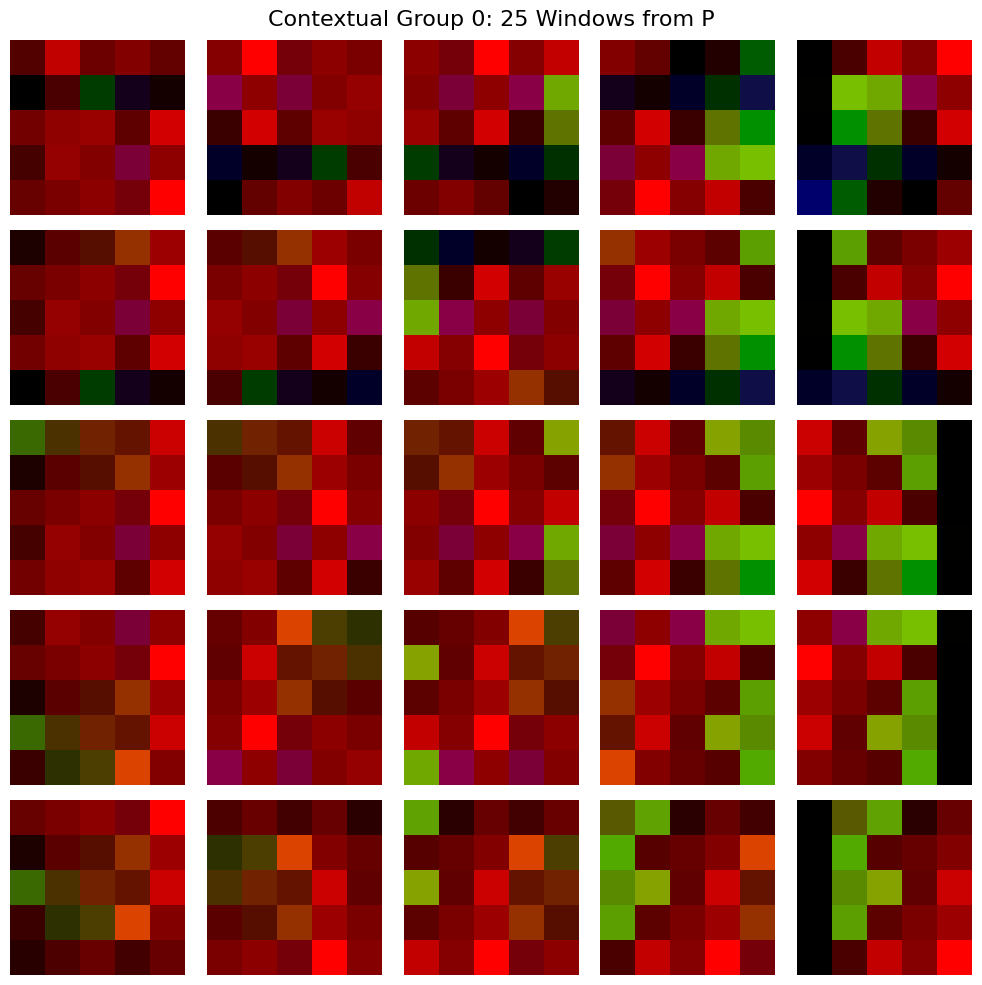

CG-CNN TRAINING (Fixed Version)
Window size:         5x5
Context radius:      ±2
Images per task:     20
Groups per task:     100
Windows per group:   25
Total tasks:         2000
EM iterations/task:  10

Task  20/2000 | E-Loss: 2.6257 | M-Loss: 2.3527 | Acc: 68.9% | Avg(20): 60.7%
Task  40/2000 | E-Loss: 2.0283 | M-Loss: 1.7062 | Acc: 75.6% | Avg(20): 73.1%
Task  60/2000 | E-Loss: 1.9515 | M-Loss: 1.6190 | Acc: 71.6% | Avg(20): 72.6%
Task  80/2000 | E-Loss: 1.9148 | M-Loss: 1.5750 | Acc: 75.7% | Avg(20): 73.2%
Task 100/2000 | E-Loss: 1.8598 | M-Loss: 1.5422 | Acc: 75.1% | Avg(20): 74.4%
Task 120/2000 | E-Loss: 1.8036 | M-Loss: 1.4647 | Acc: 74.3% | Avg(20): 75.1%
Task 140/2000 | E-Loss: 1.8034 | M-Loss: 1.4576 | Acc: 72.9% | Avg(20): 75.8%
Task 160/2000 | E-Loss: 1.7427 | M-Loss: 1.3925 | Acc: 78.4% | Avg(20): 77.6%
Task 180/2000 | E-Loss: 1.7752 | M-Loss: 1.4124 | Acc: 68.8% | Avg(20): 76.3%
Task 200/2000 | E-Loss: 1.7354 | M-Loss: 1.3773 | Acc: 81.2% | Avg(20): 77.7%
Task 220/2000 |

In [9]:
# ===============================
# 8. MAIN EXECUTION
# ===============================
if __name__ == "__main__":
    print("Loading unlabeled ISIC images...")
    dataset = ISICUnlabeledDataset(IMG_DIR)
    print(f"Loaded {len(dataset)} unlabeled images\n")

    print("Initializing dilated ResNet50...")
    backbone = DilatedResNetBackbone().to(DEVICE)
    print("✅ Backbone ready (extracts P and Q)\n")

    # Initialize trainer
    trainer = CGCNNTrainer(
        backbone=backbone,
        refiner_dim=REFINER_DIM,
        window_size=WINDOW_SIZE,
        g_radius=G_RADIUS,
        n_groups=N_GROUPS,
        device=DEVICE
    )
    # ... (after trainer initialization)
    print("Visualizing a contextual group...")
    visualize_contextual_group(dataset, trainer, group_idx=0)

    # Train CG-CNN to learn Q'
    trainer.train(
        dataset=dataset,
        n_tasks=N_TASKS,
        n_images_per_task=N_IMAGES_PER_TASK,
        em_iterations=10
    )

    # Save Q'
    trainer.save_model(MODEL_SAVE_PATH)

    # Compare Q vs Q' (uncomment when you have labeled data)
    print("\nTo compare Q vs Q', uncomment and set:")
    print("TEST_CSV = '/path/to/test_metadata.csv'")
    print("TEST_IMG_DIR = '/path/to/test/images'")
    print("compare_Q_vs_Qprime(backbone, MODEL_SAVE_PATH, TEST_CSV, TEST_IMG_DIR, DEVICE)")

In [10]:
# ===============================
# 8. MAIN EXECUTION (EVALUATION MODE)
# ===============================
if __name__ == "__main__":
    # --- UPDATE THESE PATHS ---
    TEST_CSV = "/content/drive/MyDrive/CGCNN_research/test_set/test_metadata.csv"
    TEST_IMG_DIR = "/content/drive/MyDrive/CGCNN_research/test_set/data"
    # --------------------------

    print("Initializing dilated ResNet50...")
    backbone = DilatedResNetBackbone().to(DEVICE)

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"✅ Found trained model at {MODEL_SAVE_PATH}")

        # Run the comparison
        compare_Q_vs_Qprime(
            backbone=backbone,
            refiner_path=MODEL_SAVE_PATH,
            csv_path=TEST_CSV,
            img_dir=TEST_IMG_DIR,
            device=DEVICE
        )

    else:
        print("❌ Trained model not found. Please run training first.")

Initializing dilated ResNet50...
✅ Found trained model at /content/drive/MyDrive/CGCNN_research/cgcnn_contextual.pth

DOWNSTREAM EVALUATION: Q vs Q'
Class distribution:
  Benign:    367 samples
  Malignant: 131 samples
Loaded 498 labeled examples


Testing: Q (ResNet Layer4)
  Epoch 3/10 | Loss: 0.4869
  Epoch 6/10 | Loss: 0.4297
  Epoch 9/10 | Loss: 0.4120

Q (ResNet Layer4) Results:
  AUC-ROC: 0.8786
              precision    recall  f1-score   support

      Benign      0.807     0.981     0.886       367
   Malignant      0.865     0.344     0.492       131

    accuracy                          0.813       498
   macro avg      0.836     0.662     0.689       498
weighted avg      0.822     0.813     0.782       498


Testing: Q' (CG-CNN Refined)
  Epoch 3/10 | Loss: 0.6543
  Epoch 6/10 | Loss: 0.6366
  Epoch 9/10 | Loss: 0.6219

Q' (CG-CNN Refined) Results:
  AUC-ROC: 0.5174
              precision    recall  f1-score   support

      Benign      0.737     1.000     0.849       

In [11]:
# ===============================
# 8. MAIN EXECUTION (EVALUATION MODE)
# ===============================
if __name__ == "__main__":
    # --- UPDATE THESE PATHS ---
    TEST_CSV_2 = "/content/drive/MyDrive/CGCNN_research/test_subset_2/test_subset_2_metadata.csv"
    TEST_IMG_DIR_2 = "/content/drive/MyDrive/CGCNN_research/test_subset_2/images"
    # --------------------------

    print("Initializing dilated ResNet50...")
    backbone = DilatedResNetBackbone().to(DEVICE)

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"✅ Found trained model at {MODEL_SAVE_PATH}")

        # Run the comparison
        compare_Q_vs_Qprime(
            backbone=backbone,
            refiner_path=MODEL_SAVE_PATH,
            csv_path=TEST_CSV_2,
            img_dir=TEST_IMG_DIR_2,
            device=DEVICE
        )

    else:
        print("❌ Trained model not found. Please run training first.")

Initializing dilated ResNet50...
✅ Found trained model at /content/drive/MyDrive/CGCNN_research/cgcnn_contextual.pth

DOWNSTREAM EVALUATION: Q vs Q'
Class distribution:
  Benign:    600 samples
  Malignant: 200 samples
Loaded 800 labeled examples


Testing: Q (ResNet Layer4)
  Epoch 3/10 | Loss: 0.2021
  Epoch 6/10 | Loss: 0.1718
  Epoch 9/10 | Loss: 0.1568

Q (ResNet Layer4) Results:
  AUC-ROC: 0.9841
              precision    recall  f1-score   support

      Benign      0.964     0.972     0.968       600
   Malignant      0.913     0.890     0.901       200

    accuracy                          0.951       800
   macro avg      0.938     0.931     0.934       800
weighted avg      0.951     0.951     0.951       800


Testing: Q' (CG-CNN Refined)
  Epoch 3/10 | Loss: 0.6530
  Epoch 6/10 | Loss: 0.6182
  Epoch 9/10 | Loss: 0.5891

Q' (CG-CNN Refined) Results:
  AUC-ROC: 0.9470
              precision    recall  f1-score   support

      Benign      0.750     1.000     0.857       

In [14]:
# Create the loader that the visualization functions will use
test_dataset_viz = ISICLabeledDataset(TEST_CSV_2, TEST_IMG_DIR_2)
test_loader_viz = DataLoader(test_dataset_viz, batch_size=20, shuffle=True)

Class distribution:
  Benign:    600 samples
  Malignant: 200 samples


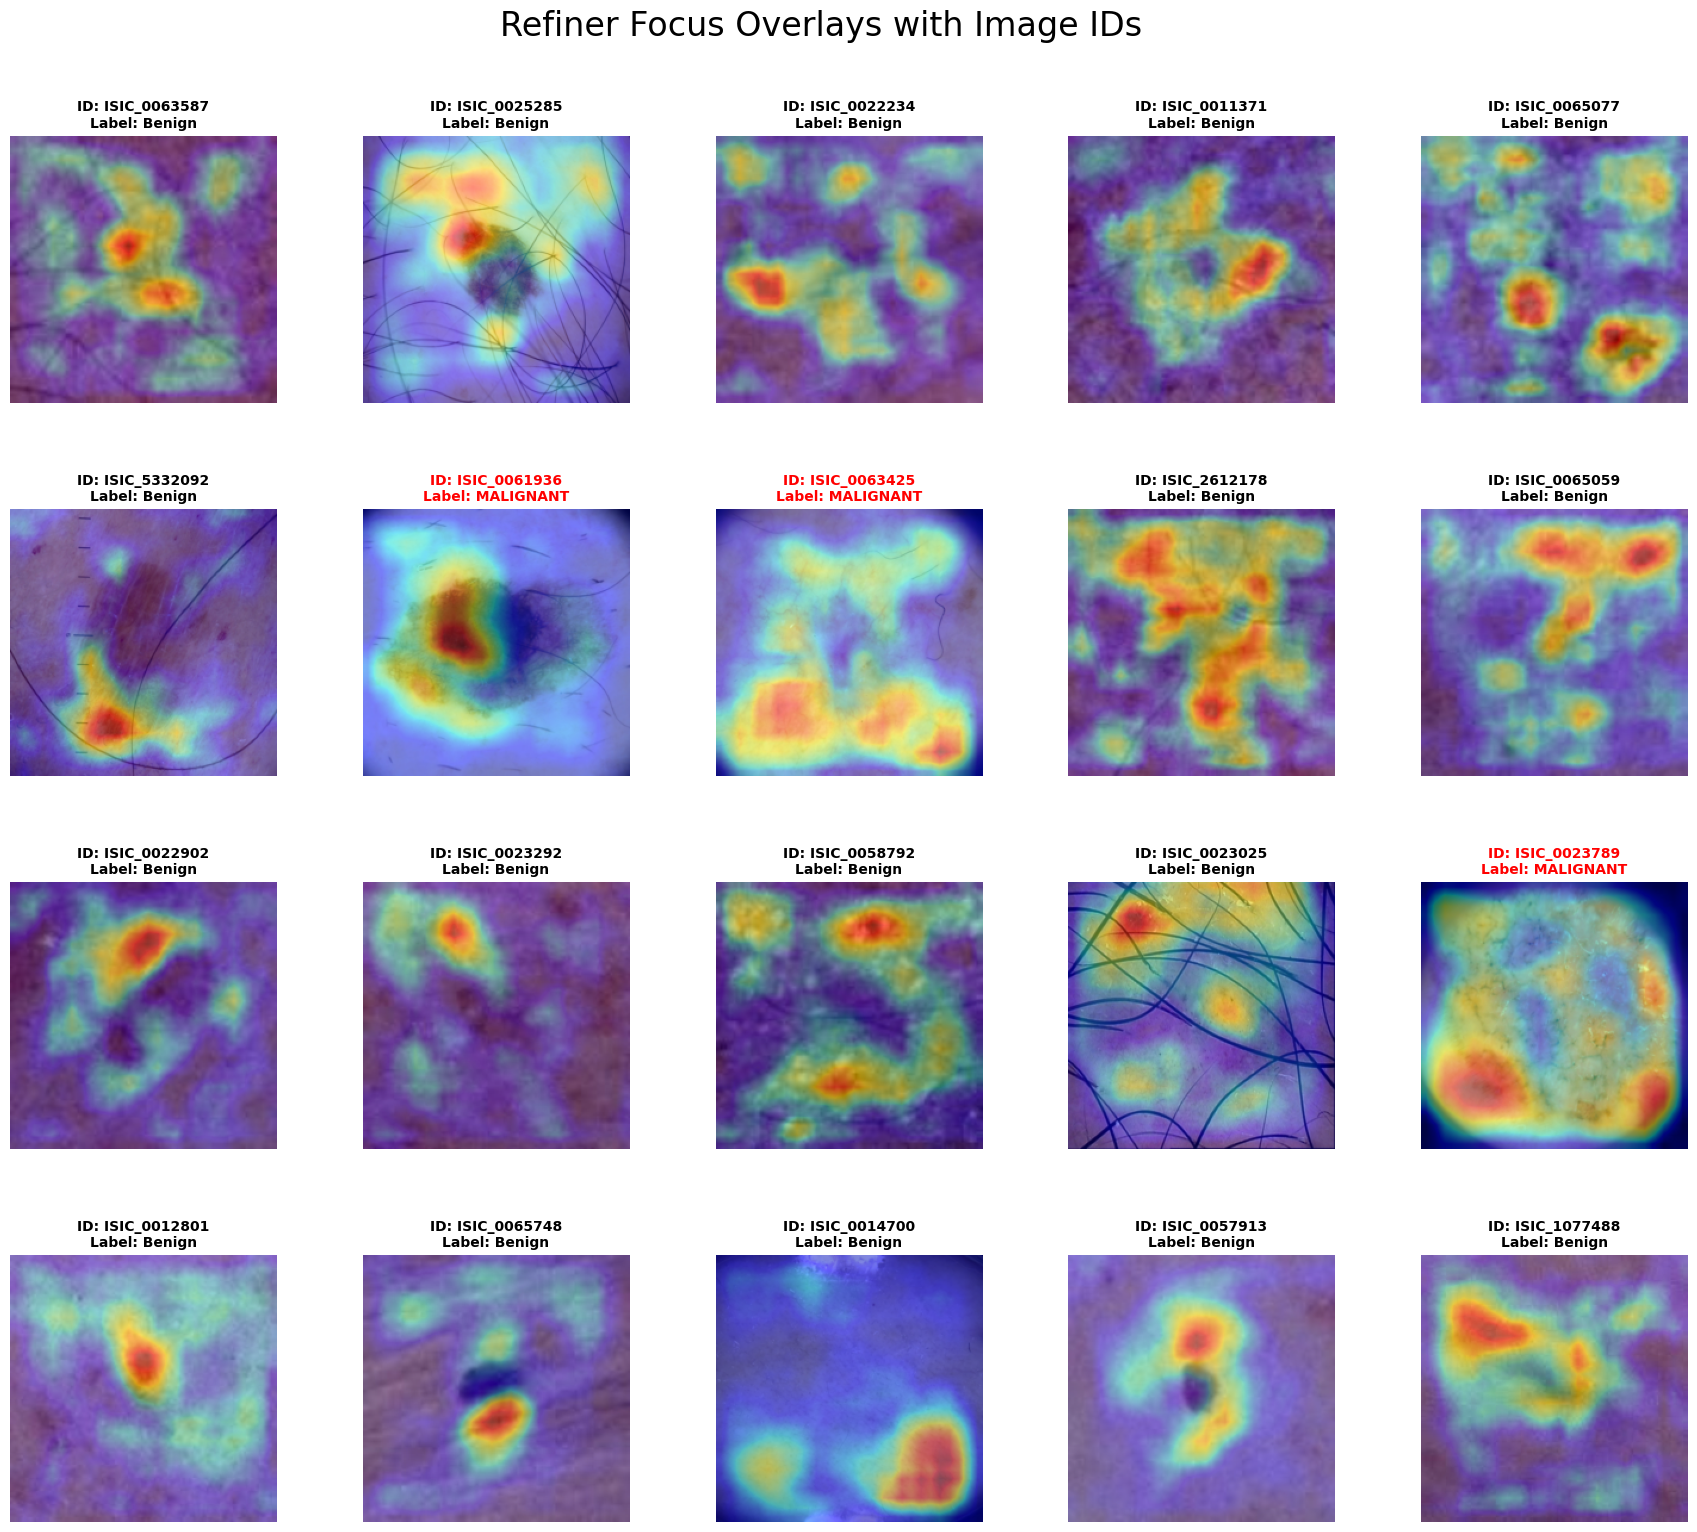

In [17]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_test_set_with_ids(trainer_obj, loader, device):
    trainer_obj.refiner.eval()
    trainer_obj.backbone.eval()

    # 1. Pull data from the loader
    # We need the dataset object to get the original paths/IDs
    dataset = loader.dataset

    # Grab a batch
    images, labels = next(iter(loader))
    images_dev = images[:20].to(device)
    labels = labels[:20]

    with torch.no_grad():
        # 2. Extract features
        P, _ = trainer_obj.backbone(images_dev)

        # 3. Get Refined Features (Q')
        Q_prime = trainer_obj.refiner(P)

        # 4. Create Heatmaps
        heatmaps = torch.mean(Q_prime, dim=1, keepdim=True)
        heatmaps = F.interpolate(heatmaps, size=(224, 224), mode='bilinear', align_corners=False)
        heatmaps = heatmaps.squeeze().cpu().numpy()

    # 5. Plotting
    fig, axes = plt.subplots(4, 5, figsize=(22, 18))
    plt.subplots_adjust(hspace=0.4)

    for i in range(20):
        ax = axes[i // 5, i % 5]

        # Get image ID from the dataset
        # This accesses the dataframe inside your ISICLabeledDataset
        row = dataset.df.iloc[i]
        img_id = row.get('isic_id', row.get('image_id', f"Index_{i}"))

        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        ax.imshow(img)
        ax.imshow(heatmaps[i], cmap='jet', alpha=0.45) # Overlay

        title_color = 'red' if labels[i] == 1 else 'black'
        diagnosis = 'MALIGNANT' if labels[i] == 1 else 'Benign'

        # Title now includes the Filename/ID
        ax.set_title(f"ID: {img_id}\nLabel: {diagnosis}",
                     color=title_color, fontsize=10, fontweight='bold')
        ax.axis('off')

    plt.suptitle("Refiner Focus Overlays with Image IDs", fontsize=24, y=0.95)
    plt.show()

# Run the updated visualization
visualize_test_set_with_ids(trainer, test_loader_viz, DEVICE)

Extracting features for t-SNE...


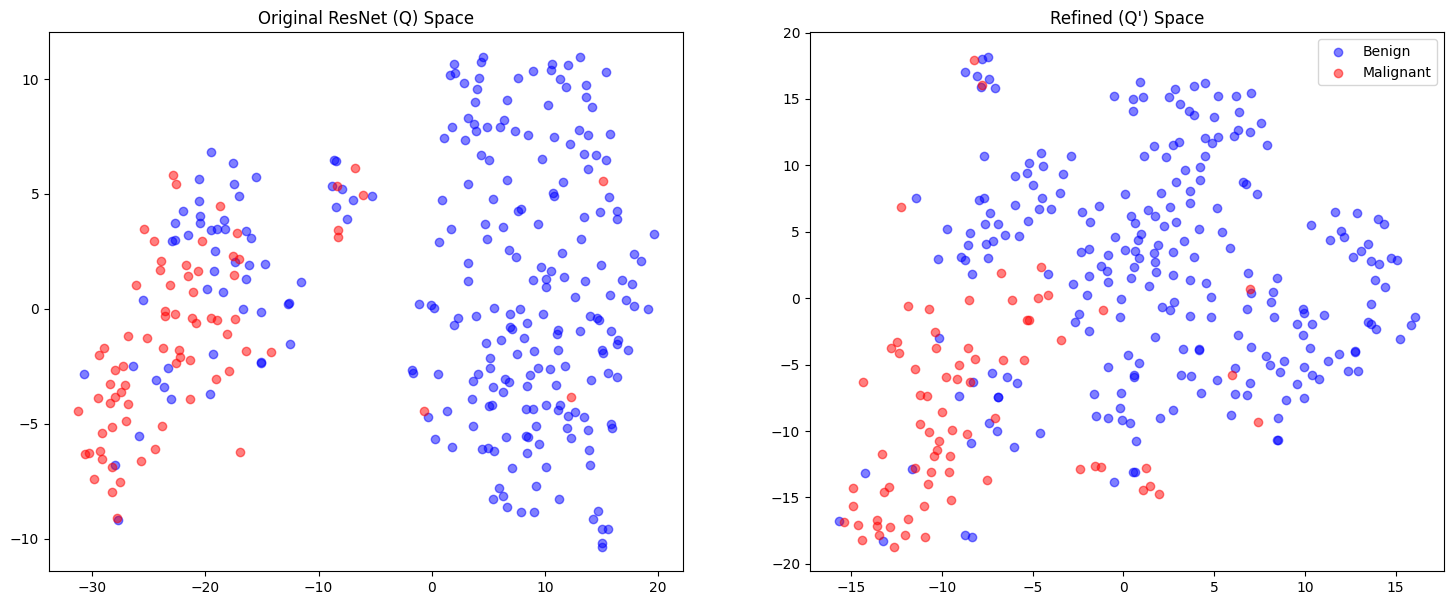

In [16]:
from sklearn.manifold import TSNE

def plot_tsne_comparison_fixed(trainer_obj, loader, device):
    trainer_obj.refiner.eval()
    q_features, qp_features, targets = [], [], []

    print("Extracting features for t-SNE...")
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            P, Q = trainer_obj.backbone(imgs)

            # Baseline Q (Layer 4)
            q_vec = F.adaptive_avg_pool2d(Q, (1, 1)).flatten(1)
            # Refined Q'
            qp_vec = trainer_obj.refiner.get_global_features(P)

            q_features.append(q_vec.cpu().numpy())
            qp_features.append(qp_vec.cpu().numpy())
            targets.append(lbls.numpy())
            if len(np.concatenate(targets)) > 300: break # Cap at 300 for speed

    q_features = np.concatenate(q_features)
    qp_features = np.concatenate(qp_features)
    targets = np.concatenate(targets)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Plot Q
    res_q = tsne.fit_transform(q_features)
    ax1.scatter(res_q[targets==0,0], res_q[targets==0,1], c='blue', label='Benign', alpha=0.5)
    ax1.scatter(res_q[targets==1,0], res_q[targets==1,1], c='red', label='Malignant', alpha=0.5)
    ax1.set_title("Original ResNet (Q) Space")

    # Plot Q'
    res_qp = tsne.fit_transform(qp_features)
    ax2.scatter(res_qp[targets==0,0], res_qp[targets==0,1], c='blue', label='Benign', alpha=0.5)
    ax2.scatter(res_qp[targets==1,0], res_qp[targets==1,1], c='red', label='Malignant', alpha=0.5)
    ax2.set_title("Refined (Q') Space")

    plt.legend()
    plt.show()

# Run the t-SNE
plot_tsne_comparison_fixed(trainer, test_loader_viz, DEVICE)